This notebook aims to figure our the general LNOx profile.

In [1]:
from distfit import distfit
import numpy as np
import proplot as pplt
import matplotlib.pyplot as plt

Data from Ott et al. (2010):

In [2]:
ott_subtrop = np.array([.010,.021,.039,.058,.077,.093,.105,.110,.110,.104,.092,.075,.055,.034,.015,.002,.000])
ott_midlat  = np.array([.024,.050,.074,.093,.106,.114,.115,.110,.099,.083,.063,.042,.022,.005,.000,.000,.000])
ott_trpcon  = np.array([.002,.005,.006,.014,.027,.040,.050,.062,.086,.103,.116,.124,.127,.124,.076,.030,.008])
ott_trpmar  = np.array([.006,.015,.029,.043,.054,.067,.077,.085,.096,.102,.105,.102,.082,.065,.045,.022,.005])
ott_trpmar_false  = np.array([.006,.015,.029,.043,.054,.067,.066,.085,.096,.102,.105,.102,.082,.065,.045,.022,.005])

ott_midlat_mod = np.array([.030,.047,.064,.101,.130,.115,.088,.093,.114,.111,.070,.023,.009,.006,.000,.000,.000]) # the two-bump profile

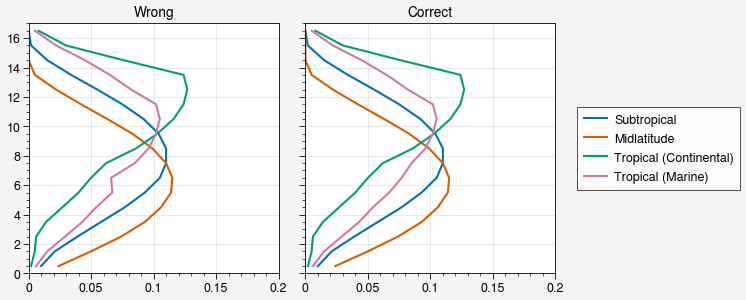

In [3]:
# https://github.com/wrf-model/WRF/pull/1696

fig, axs = pplt.subplots(ncols=2)

z = (np.arange(0, 18)[:-1]+np.arange(0, 18)[1:])/2

ax = axs[0]
l_subtrop = axs.plot(ott_subtrop, z, label='Subtropical')
l_midlat = axs.plot(ott_midlat, z, label='Midlatitude')
# axs.plot(ott_midlat_mod, z, label='Midlatitude-mod')
l_trpcon = axs.plot(ott_trpcon, z, label='Tropical (Continental)')
l_trpmar_false = ax.plot(ott_trpmar_false, z, label='Tropical (Marine)')

ax = axs[1]
l_trpmar = ax.plot(ott_trpmar, z, label='Tropical (Marine)')


fig.legend([l_subtrop[0], l_midlat[0], l_trpcon[0], l_trpmar], loc='r', ncols=1)
axs.format(xlim =(0, 0.2), ylim=(0, 17), title=['Wrong', 'Correct'])

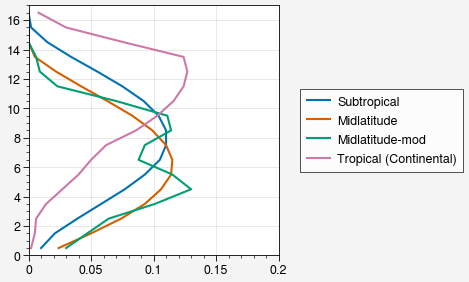

In [4]:
fig, axs = pplt.subplots()


axs.plot(ott_subtrop, z, label='Subtropical')
axs.plot(ott_midlat, z, label='Midlatitude')
axs.plot(ott_midlat_mod, z, label='Midlatitude-mod')
axs.plot(ott_trpcon, z, label='Tropical (Continental)')
ax.plot(ott_trpmar, z, label='Tropical (Marine)')

fig.legend(loc='r', ncols=1)
axs.format(xlim =(0, 0.2), ylim=(0, 17))

Fit profiles using Gaussian function

[ 0.1050638   9.35814041 -3.96159174]
[ 0.1278612  11.13716095 -3.17434457]
[ 0.11521041  7.88929496 -3.58311767]
[0.1200568  6.23403234 3.51606176]


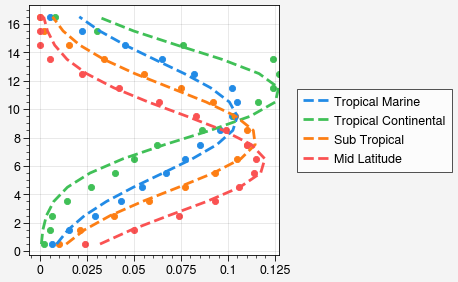

In [5]:
# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

from scipy.optimize import curve_fit

# Plot the noisy exponential data
fig, ax = pplt.subplots()

colors  = ['blue6', 'green6', 'orange6', 'red6']
labels = ['Tropical Marine', 'Tropical Continental', 'Sub Tropical', 'Mid Latitude']

for index,ydata in enumerate([ott_trpmar, ott_trpcon, ott_subtrop, ott_midlat]):
    ax.scatter(ydata, z, s=20, c=colors[index])
    pars, cov = curve_fit(f=gaussian, xdata=z, ydata=ydata)
    print(pars)
    ax.plot(gaussian(z, *pars), z, linewidth=2, linestyle='--', c=colors[index], label=labels[index])

ax.legend(loc='r', ncols=1)

Using a = 0.12, b = peak_layer (km), and c = 3.55:

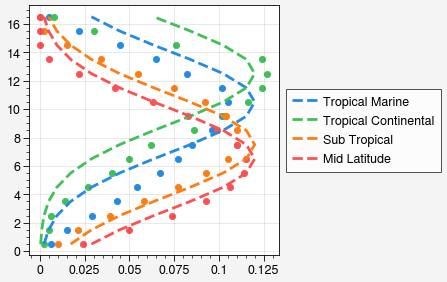

In [6]:
# Function to calculate the Gaussian with constants a, b, and c
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

from scipy.optimize import curve_fit

# Plot the noisy exponential data
fig, ax = pplt.subplots()

colors  = ['blue6', 'green6', 'orange6', 'red6']
labels = ['Tropical Marine', 'Tropical Continental', 'Sub Tropical', 'Mid Latitude']

for index,ydata in enumerate([ott_trpmar, ott_trpcon, ott_subtrop, ott_midlat]):
    ax.scatter(ydata, z, s=20, c=colors[index])
    # pars, cov = curve_fit(f=gaussian, xdata=z, ydata=ydata)
    # ax.plot(z, gaussian(z, *pars), linewidth=2, linestyle='--', c=colors[index], label=labels[index])
    ax.plot(gaussian(z, 0.12, z[ydata.argmax()], 3.55), z, linewidth=2, linestyle='--', c=colors[index], label=labels[index])

ax.legend(loc='r', ncols=1)

Although the peaks are different, the general shape can be reproduced.

If we compare it with the LNOM LNOx profile in Luo et al. (2017), it looks good:

In [7]:
import pandas as pd

df_luo = pd.read_csv('../data/luo.csv', header=None, names=['lnox', 'height'])

<a list of 1 Line2D objects>

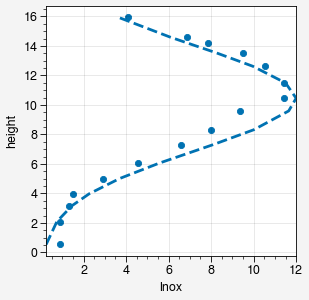

In [8]:
fig, axs = pplt.subplots()

df_luo.plot.scatter(x='lnox', y='height', ax=axs)

axs.plot(gaussian(df_luo['height'], 0.12*100, df_luo['height'][df_luo['lnox'].argmax()], 3.55),
         df_luo['height'],
        linewidth=2, linestyle='--')


So, we will use Gaussian function to generate the LNOx profile with the Cloud Pressure as the peak:

LNOx = $a * e^\frac{{-{(x - b)}^2}}{2c^{2}}$

where a = 0.12, b = cloud pressure, and c = 3.55.